In [19]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import xlsxwriter

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [20]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, get_feature_importance, get_feature_importance10, eval_matrix

### Load data

In [21]:
df = pd.read_json(r"../../data/processed/pre-processed_merged_2023_04_04.json")

### Balance data and split to train and test set

In [22]:
label_name = "phase2"
random_seed=42
random_state=42

In [23]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded, text='text_clean')

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [24]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped, text='text_clean')

### Model training (with 10-fold CV) using best parameters from GridSearch

In [28]:
# lowercase, remove stopwords
vec_0 = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words='english', 
                                  ngram_range = (1,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c_0 = 0.1
model_0=LinearSVC(C=c_0)

# lowercase, retain stopwords
vec_1 = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words=None, 
                                  ngram_range = (2,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c_1 = 5
model_1=LinearSVC(C=c_1)

In [29]:
df_metrics = pd.DataFrame(columns = ['set', 'vec', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [30]:
for i in range(0,2):    
    # balanced train
    globals()[f"pipeline_train_{i}"], globals()[f"trained_model_{i}"], globals()[f"y_predict_train_{i}"] = train_model_cross_val(X_train, y_train, vec=globals()[f"vec_{i}"], model=globals()[f"model_{i}"], cv=10)
    globals()[f"df_features_train_{i}"], _, _ = get_feature_importance(globals()[f"trained_model_{i}"], globals()[f"pipeline_train_{i}"])    
    set = "balanced train"
    metrics_train=evaluate(y_train, globals()[f"y_predict_train_{i}"])
    row_train = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                        'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                        'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])

    # balanced test
    _, globals()[f"y_predict_test1_{i}"] = train_model_test(X_train, y_train, X_test1, y_test1, model=globals()[f"model_{i}"], vec=globals()[f"vec_{i}"])
    set = "balanced test"
    metrics_test1=evaluate(y_test1, globals()[f"y_predict_test1_{i}"])
    row_test1 = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                            'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                            'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])

    # imbalanced test
    _, globals()[f"y_predict_test_{i}"] = train_model_test(X_train, y_train, X_test, y_test, model=globals()[f"model_{i}"], vec=globals()[f"vec_{i}"])
    set = "imbalanced test"
    metrics_test=evaluate(y_test, globals()[f"y_predict_test_{i}"])
    row_test = pd.DataFrame({'set':set, 'vec':i, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                        'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                        'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

    df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)
    df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.8471337579617835

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        79
           1       0.88      0.81      0.84        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157


CR: (0.8492647058823529, 0.8468841285296982, 0.8468292682926829, None)

Confusion matrix:
 [[70  9]
 [15 63]] 

_______________________


 Accuracy: 84.713 
 Precision: 0.875 
 Recall: 0.808 
 F1: 0.840 
 FPR: 0.114 
 ROC_AUC: 0.847
Accuracy: 0.8471337579617835

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        79
           1       0.88      0.81      0.84        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85     

In [31]:
df_metrics

,set,vec,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,0,70,9,15,63,0.807692,0.875000,0.840000,0.113924,84.713376,0.846884,157
1,balanced test,0,19,1,4,16,0.800000,0.941176,0.864865,0.050000,87.500000,0.875000,40
2,imbalanced test,0,1327,79,4,16,0.800000,0.168421,0.278261,0.056188,94.179523,0.871906,1426
3,balanced train,1,71,8,14,64,0.820513,0.888889,0.853333,0.101266,85.987261,0.859623,157
4,balanced test,1,18,2,3,17,0.850000,0.894737,0.871795,0.100000,87.500000,0.875000,40
5,imbalanced test,1,1253,153,3,17,0.850000,0.100000,0.178947,0.108819,89.060309,0.870590,1426


In [32]:
df_metrics.to_excel('../../output/tables/svm_metrics_p2.xlsx', index=True)

### Feature importance

In [33]:
for i in range(0,2):    
    globals()[f"df_features_train1_{i}"], globals()[f"df_features_train0_{i}"] = get_feature_importance10(globals()[f"df_features_train_{i}"])

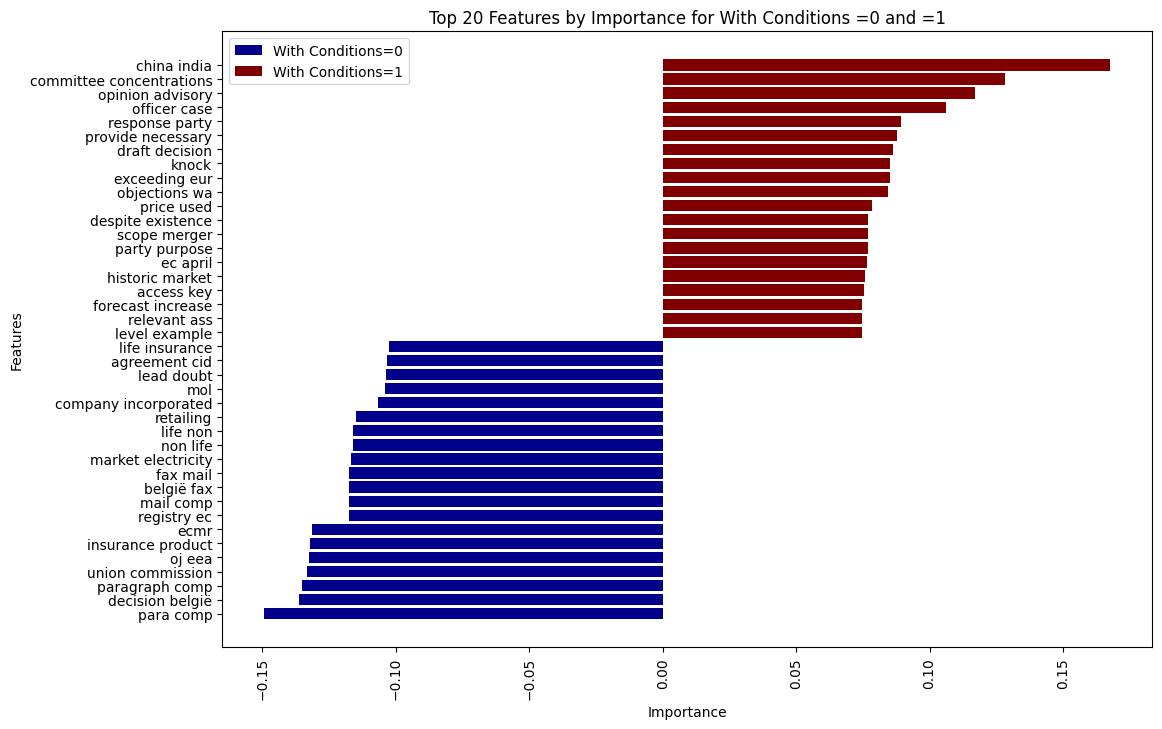

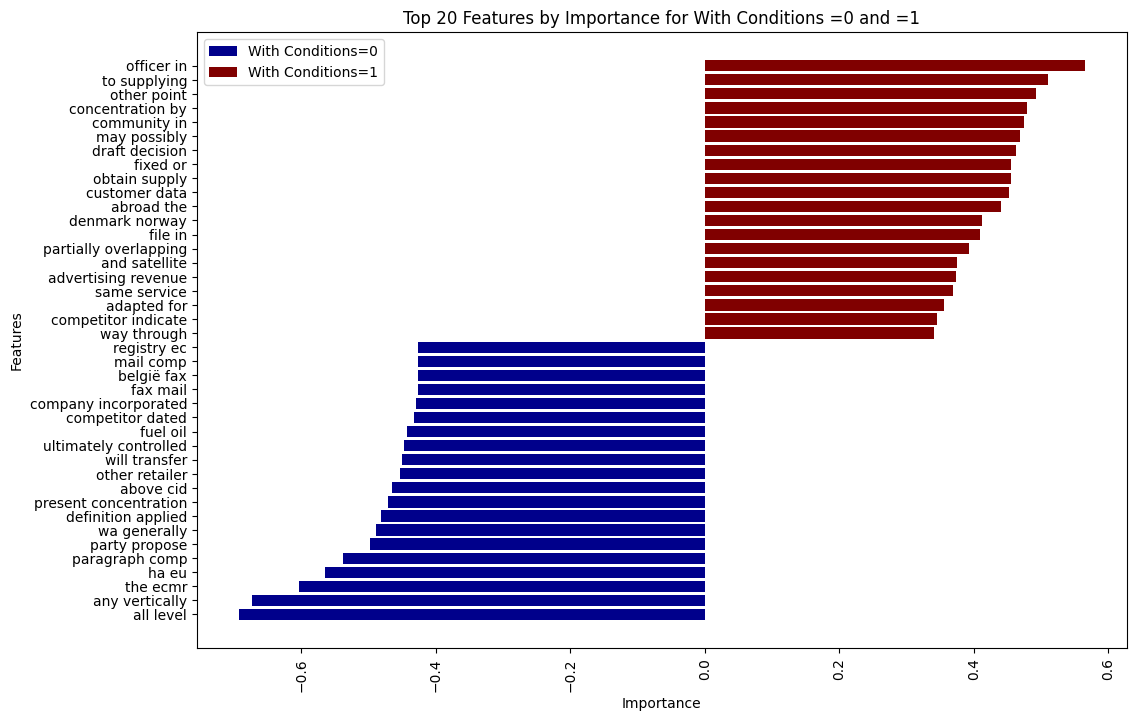

In [34]:
for i in range(0,2):  
    # Sort the features by absolute importance for label=1
    globals()[f"df_features_train1_{i}"] = globals()[f"df_features_train1_{i}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train1_top10_{i}"] = globals()[f"df_features_train1_{i}"].nlargest(20, 'abs_importance')
    globals()[f"df_features_train1_top10_{i}"] = globals()[f"df_features_train1_top10_{i}"].sort_values('importance', ascending=True)

    # Sort the features by absolute importance for label=0
    globals()[f"df_features_train0_{i}"] = globals()[f"df_features_train0_{i}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train0_top10_{i}"] = globals()[f"df_features_train0_{i}"].nlargest(20, 'abs_importance')

    # Create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(globals()[f"df_features_train0_top10_{i}"]['feature'], globals()[f"df_features_train0_top10_{i}"]['importance'], color='darkblue', label='With Conditions=0')
    ax.barh(globals()[f"df_features_train1_top10_{i}"]['feature'], globals()[f"df_features_train1_top10_{i}"]['importance'], color='maroon', label='With Conditions=1')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
    ax.legend()
    plt.xticks(rotation=90)
    #plt.show()

    plt.savefig('../../output/figures/svm_p2_' + str(i) + '.png', bbox_inches='tight')

In [35]:
for i in range(0,2):  
    globals()[f"df_features_train_{i}"].to_excel('../../output/tables/features_svm_p2_' + str(i) + '.xlsx', index=True)

In [36]:
writer = pd.ExcelWriter('../../output/tables/features_svm_p2.xlsx', engine='xlsxwriter')

for i in range(0, 2):
    sheet_name = f"Sheet_{i}"
    df = globals()[f"df_features_train_{i}"]
    df = df.sort_values(by='importance', ascending=False)
    df.to_excel(writer, sheet_name=sheet_name, index=True)

writer.close()

### Confusion matrix and model performance

In [37]:
merger_info = pd.read_json(r"../../data/processed/merger_info_2023_03_25.json")

In [38]:
writer = pd.ExcelWriter('../../output/preds/preds_svm_p2.xlsx', engine='xlsxwriter')

for j, dataset_name in enumerate(['train', 'test1', 'test']):
    for i in range(0, 2):
        preds = pd.DataFrame(np.column_stack((globals()[f"X_{dataset_name}"], globals()[f"y_{dataset_name}"], globals()[f"y_predict_{dataset_name}_{i}"])), columns=['text', 'target', 'y_predict'])
        preds = pd.concat([globals()[f"df_{dataset_name}_grouped"], preds], axis=1)[['case_num', 'article', 'text', 'target', 'y_predict']]
        preds = pd.merge(preds, merger_info[['case_code', 'article', 'nace_code']], how='left', left_on=['case_num', 'article'], right_on=['case_code', 'article'])
        
        preds.loc[(preds.target == 0) & (preds.y_predict == 0), 'cm'] = 'tn'
        preds.loc[(preds.target == 0) & (preds.y_predict == 1), 'cm'] = 'fp'
        preds.loc[(preds.target == 1) & (preds.y_predict == 0), 'cm'] = 'fn'
        preds.loc[(preds.target == 1) & (preds.y_predict == 1), 'cm'] = 'tp'

        preds.to_excel(writer, sheet_name=f"preds_{dataset_name}_{i}", index=True)

writer.close()
